# ORCHIDSS Wide DDF Target Selection

In [1]:
%matplotlib inline

In [2]:
# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

sys.path.append('/Users/duncan/Astro/WEAVE/WEAVE-SWG/mos/')

Thu May 16 18:17:56 2024

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

               numpy : 1.23.3
               scipy : 1.9.1
          matplotlib : 3.5.1
             astropy : 5.3.3
                eazy : 0.5.2.dev64
            prospect : 1.1.0


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext
from astropy.io import fits
from astropy.wcs import WCS

import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 

EAZYCODE = Users/duncan/Astro/code/eazy-py/eazy-photoz


In [4]:
def calcflux(SED, wave, filt, units):
    """ Convolve synthetic SEDs with a given filter

    Arguments
    ---------
        SED : numpy.array
            Grid of synthetic spectra
        filt : '~smpy.Filter' class
            Filter through which to convolve SED grid
        z : float
            Redshift at which models are to be observed
        dl : '~astropy.units.Quantity'
            Luminosity distance corresponding to redshift(z) in given
            cosmology.
        units : '~astropy.units'
            Desired output flux units (in spectral flux density)

    Returns
    -------
        Flux : '~astropy.units.Quantity'
            Spectral flux density, with exact units as given by 'units'

    """
    # Find SED wavelength entries within filter range
    wff = np.logical_and(filt.wave[0] < wave,
                         wave < filt.wave[-1])
    wft = wave[wff]

    # Interpolate to find throughput values at new wavelength points
    tpt = griddata(filt.wave, filt.response, wft)

    # Join arrays and sort w.r.t to wf
    # Also replace units stripped by concatenate
    wf = np.array(np.concatenate((filt.wave, wft))) * u.AA
    tp = np.concatenate((filt.response, tpt))

    order = np.argsort(wf)
    wf = wf[order]
    tp = tp[order]

    # Interpolate redshifted SED and LyAbs at new wavelength points
    sed = griddata(wave, SED.T, wf).T * SED.unit
    #lyabs = griddata(wave, self.lyman_abs, wf)

    # Calculate f_nu mean
    # Integrate SED through filter, as per BC03 Fortran
    # As: f_nu=int(dnu Fnu Rnu/h*nu)/int(dnu Rnu/h*nu)
    # ie: f_nu=int(dlm Flm Rlm lm / c)/int(dlm Rlm/lm)
    top = np.trapz(sed * tp * wf /
                   c.c.to(u.AA / u.s), wf)
    bottom = np.trapz(tp / wf, wf)
    #area = (4 * np.pi * (dl ** 2))
    Flux = top / bottom #/ (1 + z) / area

    return Flux.to(units)

def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz > 0.00)
    print('NGD: {0}'.format(cut.sum()))
    dz = photoz - specz

    ol1 = (np.abs(dz)/(1+specz) > 0.2)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (np.abs(dz)/(1+specz) > 5*nmad )
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))

    print('NMAD: {0:.4f}'.format(nmad))
    print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut]/(1+specz[cut]))))
    print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut])))
    print('OLF: Def1 = {0:.4f} Def2 = {1:0.4f}'.format(OLF1, OLF2))
    print('\n')

    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return ol1_s, ol2_s, np.nanmedian(dz[ol1_s]/(1+specz[ol1_s]))



from scipy.special import erf
from scipy.special import ndtri, ndtr

from mocpy import MOC

nanomaggy_to_ujy = 10 ** ((23.9 - 22.5) / 2.5)

def pbelowz(zphot, zerr, zcut):
    dz = zphot - zcut
    sigma_abs = (np.abs(dz)/zerr)

    psigma_abs = ndtr(sigma_abs)
    
    psigma = np.copy(psigma_abs)
    psigma[dz > 0.] = 1-psigma_abs[dz > 0.]
    
    return psigma


In [5]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

## Overall outline

The broad steps in the final ORCHIDSS sample selection are as follows:
1. Make photo-z selection from DESI Legacy Surveys (DR8) Photometry and associated photometric redshifts (Duncan 2022)
2. Match the sample to the MIGHTEE DR1(2) radio catalogue and perform forced photometry on the associated mosaic.
3. Perform template fitting at fixed `z_phot` to measure UVJ colours and SFR estimates for template matching to the S7 WAVES template set. (Based on sSFR and dust extinction since full WISE photometry not available).
4. Assign templates and construct 4MOST formatted catalogue for submission.

In [6]:
xmm_phot = Table.read('../InputCatalogues/optical/ls_dr8_xmm.fits')

xmm_pz = Table.read('../InputCatalogues/photoz/lsdr8_pz_xmm.fits')

xmm_merged = join(xmm_phot, xmm_pz, 
                  keys=['release', 'brickid', 'objid', 'type', 'ra', 'dec'])

In [7]:
# Calculated integrated probability below threshold redshift
wide_prob = pbelowz(xmm_merged['zphot'], 
                    xmm_merged['zphot_err'], 0.57) 

zcut = ((wide_prob > 0.80) * # High photo-z selection probability
        (xmm_merged['flag_qual'] == 1) * # Reliable redshift
        (xmm_merged['zphot'] > 0.)) # Physical redshift for any missed by above

### MIGHTEE Forced Photometry

To push the limits of the MIGHTEE data to incorporate faint SF radio sources. We perform forced photometry measurements on the positions of the optical sources within the MIGHTEE footprint. Assuming that sources are unresolved in the 8.9" image, we measure sources as the peak flux $S_{\nu, \text{1.3GHz}}$, with the noise measured from the RMS image at the source location.

To ensure accurate matches and forced photometry measurements, we first check for any systematic offset in the astrometry between the Legacy DR8 frame (GAIA DR2) and the MIGHTEE imaging.

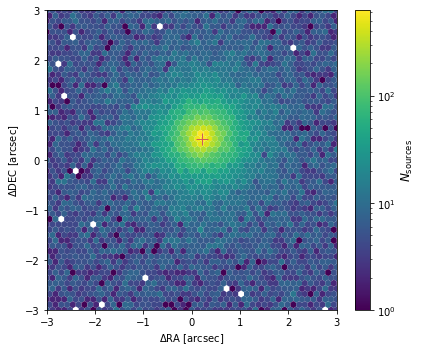

In [8]:
xmm_coord = SkyCoord(xmm_merged['ra'], xmm_merged['dec'], unit='deg')

xmm_mightee_cat = Table.read('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.gaul.fits')
mightee_coords = SkyCoord(xmm_mightee_cat['RA'], xmm_mightee_cat['DEC'], unit='deg')

idx, d2d, d3d = xmm_coord.match_to_catalog_sky(mightee_coords)

cat_match = (d2d < 1.5*u.arcsec)

# Calculate global offsets
dRA = xmm_coord.ra - mightee_coords[idx].ra
dDEC = xmm_coord.dec - mightee_coords[idx].dec

# Calculate median offset for likely matches
dRA_median = np.median(dRA[cat_match]).to(u.arcsec)
dDEC_median = np.median(dDEC[cat_match]).to(u.arcsec)

# Apply offset to LS DR8 coordinates 
xmm_coord_offset = SkyCoord(xmm_coord.ra - dRA_median, xmm_coord.dec - dDEC_median)

idxc, d2dc, d3dc = xmm_coord_offset.match_to_catalog_sky(mightee_coords)
cat_match_corr = (d2dc < 1.5*u.arcsec)

Fig, Ax = plt.subplots(1,1, figsize=(6,5))

Hx = Ax.hexbin(dRA.to(u.arcsec), dDEC.to(u.arcsec), extent=[-3, 3, -3, 3], 
          bins='log', edgecolors=None, gridsize=50)
Ax.plot(dRA_median, dDEC_median, '+', color='indianred', ms=12)
Ax.set_xlim([-3, 3])
Ax.set_ylim([-3, 3])
Ax.set_xlabel(r'$\Delta \rm{RA}$ [arcsec]')
Ax.set_ylabel(r'$\Delta \rm{DEC}$ [arcsec]')
Cb = Fig.colorbar(Hx)
Cb.set_label(r'$N_{\rm{sources}}$', size=12)
Fig.tight_layout()

In [9]:
xmm_data = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1.fits')
xmm_rms = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.rms.fits')
xmm_wcs = WCS(xmm_data[0].header, naxis=2)

xmm_img = xmm_data[0].data.squeeze()
xmm_rms_img = xmm_rms[0].data.squeeze()

# Forced phot at initial positions
xpix, ypix = xmm_wcs.world_to_array_index(xmm_coord)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < xmm_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < xmm_img.shape[0]))

flux_peak_raw = xmm_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms_raw = xmm_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr_raw = np.zeros(len(xmm_merged))
mightee_snr_raw[in_footprint] = (flux_peak_raw/flux_rms_raw)
mightee_flux_raw = np.zeros(len(xmm_merged))
mightee_flux_raw[in_footprint] = flux_peak_raw*1e6

# Forced phot with offset applied
xpix, ypix = xmm_wcs.world_to_array_index(xmm_coord_offset)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < xmm_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < xmm_img.shape[0]))

flux_peak = xmm_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms = xmm_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr = np.zeros(len(xmm_merged))
mightee_snr[in_footprint] = (flux_peak/flux_rms)
mightee_flux = np.zeros(len(xmm_merged))
mightee_flux[in_footprint] = flux_peak*1e6

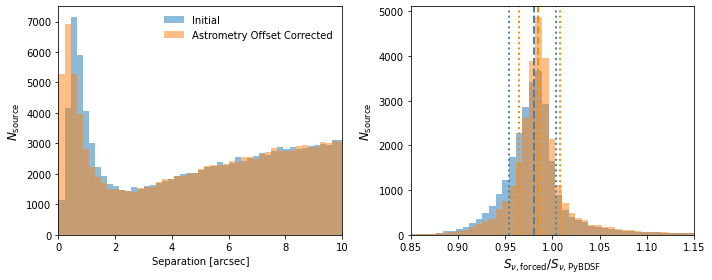

In [10]:
Fig, Ax = plt.subplots(1,2, figsize=(10, 4))

# Matching radius test
Ax[0].hist(d2d.to(u.arcsec).value, range=(0,15), bins=70, alpha=0.5, label='Initial')
Ax[0].hist(d2dc.to(u.arcsec).value, range=(0,15), bins=70, alpha=0.5, label='Astrometry Offset Corrected')
Ax[0].set_xlim([0, 10])
Ax[0].set_xlabel('Separation [arcsec]')
Ax[0].set_ylabel(r'$N_{\rm{source}}$', size=12)
Leg1 = Ax[0].legend(loc='upper right', frameon=False)

# Flux comparison - forced vs catalogue
fratio_raw = mightee_flux_raw[cat_match]/(xmm_mightee_cat['Peak_flux'][idx[cat_match]]*1e6)
fr16r, fr50r, fr84r = np.nanpercentile(fratio_raw, [16, 50, 84])

fratio = mightee_flux[cat_match_corr]/(xmm_mightee_cat['Peak_flux'][idx[cat_match_corr]]*1e6)
fr16, fr50, fr84 = np.nanpercentile(fratio, [16, 50, 84])

Ax[1].hist(fratio_raw, bins=100, range=(0.8, 1.5), alpha=0.5)
Ax[1].hist(fratio, bins=100, range=(0.8, 1.5), alpha=0.5)

ymax = Ax[1].get_ylim()[1]
Ax[1].vlines(fr50r, ymax=ymax, ymin=0., color='steelblue', ls='--', lw=2)
Ax[1].vlines([fr16r, fr84r], ymax=ymax, ymin=0., color='steelblue', ls=':', lw=2)

Ax[1].vlines(fr50, ymax=ymax, ymin=0., color='darkorange', ls='--', lw=2)
Ax[1].vlines([fr16, fr84], ymax=ymax, ymin=0., color='darkorange', ls=':', lw=2)

Ax[1].set_ylim([0, ymax])
Ax[1].set_xlim([0.85, 1.15])
Ax[1].set_xlabel(r'$S_{\nu, \rm{forced}} / S_{\nu, \rm{PyBDSF}}$', size=12)
Ax[1].set_ylabel(r'$N_{\rm{source}}$', size=12)

Fig.tight_layout()

In [11]:
mag_z_mw = 23.9 - 2.5*np.log10((xmm_merged['flux_z']*nanomaggy_to_ujy)/xmm_merged['mw_transmission_z'])

mightee_forced = (mightee_snr > 4)*(mightee_flux > 15)
mightee_catalogue = cat_match_corr * (xmm_mightee_cat['Total_flux'][idxc]*1e6 > 15)
mightee_selection = np.logical_or(mightee_forced, mightee_catalogue)

print(f"MIGHTEE Catalogue Gaussians not picked up in forced photometry: {(mightee_catalogue * np.invert(mightee_forced) * zcut).sum()}" )
print(f"MIGHTEE Forced photometry sources not in PyBDSF catalogue: {(mightee_forced * np.invert(cat_match_corr) * zcut).sum()}" )

orchidss_selection = mightee_selection * zcut * (mag_z_mw < 24.)

print(f"Total sample: {orchidss_selection.sum()}")

MIGHTEE Catalogue Gaussians not picked up in forced photometry: 220
MIGHTEE Forced photometry sources not in PyBDSF catalogue: 10246
Total sample: 23247


## Template assignment

1. Fit the g,r,z,W1,W2 photometry from LS DR8 with EazyPy, where the redshift is fixed to the photo-z estimate from the GPz estimates. This requires intermediate steps of converting fluxes to extinction corrected uJy fluxes.
2. Use the Eazy SPS fitting with the SFHZ template set to infer an approximate sSFR and rest-frame optical colours to enable catalogue matching. (Note that the S7 ETC templates have limited coverage. So this intermediate step should ensure a slightly better match than optical alone that will not include WISE information).
3. Measure the rest-frame U-B and B-V colours of the S7 template set.
4. Assign templates to the ORCHIDSS sample using a kNN Classifier based on 3 properties: sSFR, U-B (rest), B-V (rest). Given the now reduced template coverage, only approximage matching is necessary. So small differences in the sSFR at the low end for passive objects should have negligible impact on the resulting ETC estimates.

In [12]:
filters = [col.split('_')[1] for col in xmm_merged.colnames if 
           col.startswith('flux_') and col.find('ivar') == -1]
print(filters)

xmm_eazy_input = xmm_merged[['id', 'ra', 'dec', 'type']].copy()

for filt in filters:
    xmm_eazy_input[f'flux_{filt}'] = ((xmm_merged[f'flux_{filt}'] * nanomaggy_to_ujy) / 
                                      xmm_merged[f'mw_transmission_{filt}'])
    xmm_eazy_input[f'fluxerr_{filt}'] = (((1/np.sqrt(xmm_merged[f'flux_ivar_{filt}'])) * nanomaggy_to_ujy) / 
                                         xmm_merged[f'mw_transmission_{filt}'])
    

xmm_eazy_input['z_spec'] = xmm_merged['zphot'] # Fix redshift to GPz zphot

xmm_eazy_input = xmm_eazy_input[orchidss_selection]

xmm_eazy_input.write('eazy_input/lsdr8_pz_xmm_eazy_input.cat', 
                     format='ascii.commented_header', overwrite=True)

['g', 'r', 'z', 'w1', 'w2', 'w3', 'w4']


In [13]:
template_sets = ['templates/sfhz/corr_sfhz_13.param']

pzruns = []

for i, templates in enumerate(template_sets[:]):
    params = {}
    params['CATALOG_FILE'] = 'eazy_input/lsdr8_pz_xmm_eazy_input.cat'

    params['MAIN_OUTPUT_FILE'] = 'owide_tempfit'

    # Galactic extinction
    params['MW_EBV'] = 0.00
    params['CAT_HAS_EXTCORR'] = True

    params['Z_STEP'] = 0.01
    params['Z_MIN'] = 0.0
    params['Z_MAX'] = 0.6
    params['Z_STEP_TYPE'] = 0

    params['SYS_ERR'] = 0.05
    params['APPLY_PRIOR'] = 'N'
    params['PRIOR_FILTER'] = 380
    params['PRIOR_ABZP'] = 23.9 
    params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

    params['TEMPLATES_FILE'] = os.path.join('/', os.getenv('EAZYCODE'), templates)
    params['FIX_ZSPEC'] = True

    params['IGM_SCALE_TAU'] = 1.0

    translate_file = os.path.join(os.getenv('EAZYCODE'), 'inputs/zphot.translate')


    translate = Table()
    translate['filt'] = ['id', 'z_spec'] + [col for col in xmm_eazy_input.colnames if col.startswith('flux')][:-4]


    translate['num'] = ['id', 'z_spec',
                        'F294', 'E294',
                        'F295', 'E295',
                        'F297', 'E297',
                        'F244', 'E244',
                        'F245', 'E245',
                       ]

    translate_file = os.path.join('/', os.getenv('EAZYCODE'), 'inputs/zphot.translate')

    translate.write(translate_file, format='ascii.no_header', overwrite=True)
    
    pzfit = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                               zeropoint_file=None, 
                               params=params, 
                               load_prior=True, load_products=False)

    # Turn off error corrections derived above
    pzfit.set_sys_err(positive=True)

    # fit_parallel renamed to fit_catalog 14 May 2021
    pzfit.fit_catalog(pzfit.idx, n_proc=12)
    
    pzruns.append(pzfit)

Read default param file: /Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: eazy_input/lsdr8_pz_xmm_eazy_input.cat
   >>> NOBJ = 23247
flux_g fluxerr_g (294): DECam/DECam_g.txt
flux_r fluxerr_r (295): DECam/DECam_r.txt
flux_z fluxerr_z (297): DECam/DECam_z.txt
flux_w1 fluxerr_w1 (244): WISE/RSR-W1.txt
flux_w2 fluxerr_w2 (245): WISE/RSR-W2.txt
Set sys_err = 0.05 (positive=True)
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Template grid: /Users/duncan/Astro/code/eazy-py/eazy-photoz/templates/sfhz/corr_sfhz_13.param (this may take some time)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


Template   0: corr_sfhz_13_bin0_av0.01.fits (NZ=14).
Template   1: corr_sfhz_13_bin0_av0.25.fits (NZ=14).
Template   2: corr_sfhz_13_bin0_av0.50.fits (NZ=14).
Template   3: corr_sfhz_13_bin0_av1.00.fits (NZ=14).
Template   4: corr_sfhz_13_bin1_av0.01.fits (NZ=14).
Template   5: corr_sfhz_13_bin1_av0.25.fits (NZ=14).
Template   6: corr_sfhz_13_bin1_av0.50.fits (NZ=14).
Template   7: corr_sfhz_13_bin1_av1.00.fits (NZ=14).
Template   8: corr_sfhz_13_bin2_av0.01.fits (NZ=14).
Template   9: corr_sfhz_13_bin2_av0.50.fits (NZ=14).
Template  10: corr_sfhz_13_bin2_av1.00.fits (NZ=14).
Template  11: corr_sfhz_13_bin3_av0.01.fits (NZ=14).
Template  12: corr_sfhz_13_bin3_av0.50.fits (NZ=14).
Process templates: 4.835 s


60it [00:00, 570.17it/s]


Set sys_err = 0.05 (positive=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.80it/s]


Compute best fits
fit_best: 3.1 s (n_proc=2,  NOBJ=23247)
Fit 16.1 s (n_proc=10, NOBJ=23247)


In [14]:
from astropy.cosmology import FlatLambdaCDM
from mocpy import MOC

cos = FlatLambdaCDM(H0=70, Om0=0.3)

templist = Table.read('../ETC_Templates/S7_temps_FINAL/S7_temps_FINALprops.csv')
templist = templist[templist['veldisp'] == 45]

sps_fit = pzfit.sps_parameters(cosmology=cos, extra_rf_filters=[], percentile_limits=[16, 50, 84], n_proc=8)

cat_ssfr = np.log10(sps_fit['sfr']/sps_fit['mass'])
cat_av = sps_fit['Av']

temp_ssfr = np.log10(templist['SFR']/10**(templist['logmstar']))
temp_av = templist['tau_screen'] * 1.0857

  0%|                                                                                                         | 0/3 [00:00<?, ?it/s]/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/photoz.py:6121: RuntimeWarning: covariance is not positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],
/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/eazy/photoz.py:6121: RuntimeWarning: covariance is not positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:43<00:00, 14.48s/it]

 ... rest-frame flux: 43.5 s (n_proc=3,  NOBJ=23247)


In [15]:
cat_uv = -2.5*np.log10(sps_fit['restU']/sps_fit['restV'])
cat_ub = -2.5*np.log10(sps_fit['restU']/sps_fit['restB'])
cat_bv = -2.5*np.log10(sps_fit['restB']/sps_fit['restV'])

In [16]:
from dustmaps.config import config
config.reset()
from dustmaps.sfd import SFDQuery

xmm_sample = xmm_merged[orchidss_selection]

extent = np.zeros(len(xmm_sample), dtype='int')
extent_index = np.zeros(len(xmm_sample))
extent_parameter = np.zeros(len(xmm_sample))

# DeV
dev = (xmm_sample['type'] == 'DEV')
extent[dev] = 2
extent_index[dev] = 4.0
extent_parameter[dev] = xmm_sample['shapedev_r'][dev]

# EXP
exp = ((xmm_sample['type'] == 'EXP') + (xmm_sample['type'] == 'REX') + (xmm_sample['type'] == 'COMP'))
extent[exp] = 2
extent_index[exp] = 1.0
extent_parameter[exp] = xmm_sample['shapeexp_r'][exp]


In [17]:
import smpy.smpy as S
from scipy.interpolate import griddata
import astropy.constants as c
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

filtset = S.LoadEAZYFilters('FILTER.RES.latest')

filters = S.FilterSet()
filters.addEAZYFilter(filtset, [152, 153, 154, 160])

templist = Table.read('../ETC_Templates/S7_temps_FINAL/S7_temps_FINALprops.csv')
templist = templist[templist['veldisp'] == 45]

temp_seds = []

for i, tempName in enumerate(tqdm(templist["tempName"][:])):
    temp = Table.read(f'../ETC_Templates/S7_temps_FINAL/{tempName}.fits')
    
    if i == 0:
        temp_lambda = temp["LAMBDA"]
        
    temp_seds.append(temp["FLUX_DENSITY"])

temp_seds = np.array(temp_seds)*temp_seds[0].unit

temp_fluxes = []
for filt in filters.filters[:-1]:
    fluxes = calcflux(temp_seds, temp_lambda, filt, units=u.uJy)
    temp_fluxes.append(fluxes)
    
temp_fluxes = np.array(temp_fluxes)*u.uJy

temp_ub = -2.5*np.log10(temp_fluxes[0]/temp_fluxes[1])
temp_bv = -2.5*np.log10(temp_fluxes[1]/temp_fluxes[2])
temp_uv = -2.5*np.log10(temp_fluxes[0]/temp_fluxes[2])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:01<00:00, 207.00it/s]


In [18]:
X = np.array([temp_ssfr, temp_ub, temp_bv]).T
X[np.isinf(X)] = -100 
y = np.arange(len(temp_ssfr))

x_in = np.array([cat_ssfr, cat_ub, cat_bv]).T

x_in[x_in[:,0] < -13, 0] = -16.
for i in range(3):
    x_in[np.isinf(x_in[:,i]), i] = np.nanmedian(x_in[:,i])
    x_in[np.isnan(x_in[:,i]), i] = np.nanmedian(x_in[:,i])

knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

temp_match = knn.predict(x_in)

/Users/duncan/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


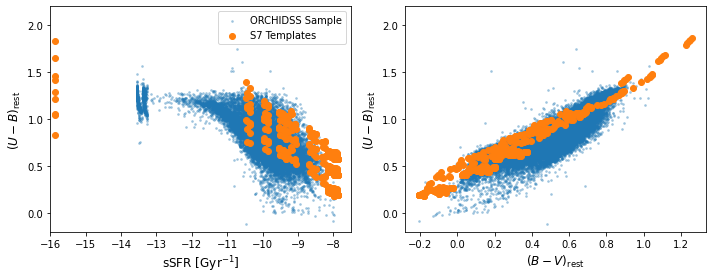

In [19]:
Fig, Ax = plt.subplots(1, 2, figsize=(10, 4))
Ax[0].scatter(cat_ssfr, cat_ub,s=3, alpha=0.3, label='ORCHIDSS Sample')
Ax[0].scatter(temp_ssfr, temp_ub, label='S7 Templates')
Ax[0].set_xlim([-16, -7.5])
Ax[0].set_ylim([-0.2, 2.2])
Ax[0].set_xlabel(r'sSFR [Gyr$^{-1}$]', size=12)
Ax[0].set_ylabel(r'$(U-B)_{\rm{rest}}$', size=12)

Leg = Ax[0].legend(loc='upper right')

Ax[1].scatter(cat_bv, cat_ub, s=3, alpha=0.3)
Ax[1].scatter(temp_bv, temp_ub)
Ax[1].set_ylabel(r'$(U-B)_{\rm{rest}}$', size=12)
Ax[1].set_xlabel(r'$(B-V)_{\rm{rest}}$', size=12)
Ax[1].set_ylim([-0.2, 2.2])

Fig.tight_layout()

## Final catalogue construction

In [20]:
name = np.array(['WD02_'+str(idn) for idn in xmm_sample['id']])

orchidsswide_xmm = Table()
orchidsswide_xmm['NAME'] = name
orchidsswide_xmm['RA'] = xmm_sample['ra']
orchidsswide_xmm['DEC'] = xmm_sample['dec']
orchidsswide_xmm['MAG'] = 22.5 - 2.5*np.log10(xmm_sample['flux_r'])
orchidsswide_xmm['MAG_ERR'] = 2.5*np.log10(np.e) * 1/(xmm_sample['flux_r']*np.sqrt(xmm_sample['flux_ivar_r']))
orchidsswide_xmm['MAG_TYPE'] = 'DECam_r_AB'
orchidsswide_xmm['REDSHIFT_ESTIMATE'] = xmm_sample['zphot']
orchidsswide_xmm['REDSHIFT_ERROR'] = xmm_sample['zphot_err']

orchidsswide_xmm['EXTENT_FLAG'] = extent
orchidsswide_xmm['EXTENT_INDEX'] = extent_index
orchidsswide_xmm['EXTENT_PARAMETER'] = extent_parameter

scoord = SkyCoord(orchidsswide_xmm['RA']*u.deg, orchidsswide_xmm['DEC']*u.deg)

sfd = SFDQuery()
ebv = sfd(scoord)

orchidsswide_xmm['REDDENING'] = ebv

orchidsswide_xmm['TEMPLATE'] = templist['tempName'][temp_match]
orchidsswide_xmm['FIELD'] = 'WD02'

orchidsswide_xmm['flux_g'] = xmm_sample['flux_g']*3.631
orchidsswide_xmm['fluxerr_g'] = 1/np.sqrt(xmm_sample['flux_ivar_g'])*3.631

orchidsswide_xmm['flux_r'] = xmm_sample['flux_r']*3.631
orchidsswide_xmm['fluxerr_r'] = 1/np.sqrt(xmm_sample['flux_ivar_r'])*3.631

orchidsswide_xmm['flux_z'] = xmm_sample['flux_z']*3.631
orchidsswide_xmm['fluxerr_z'] = 1/np.sqrt(xmm_sample['flux_ivar_z'])*3.631

orchidsswide_xmm['flux_w1'] = xmm_sample['flux_w1']*3.631
orchidsswide_xmm['fluxerr_w1'] = 1/np.sqrt(xmm_sample['flux_ivar_w1'])*3.631

orchidsswide_xmm['flux_w2'] = xmm_sample['flux_w2']*3.631
orchidsswide_xmm['fluxerr_w2'] = 1/np.sqrt(xmm_sample['flux_ivar_w2'])*3.631

for col in ['Source_id', 'Total_flux', 'E_Total_flux']:
    dtype = xmm_mightee_cat[col].dtype
    new_col = np.full(len(orchidsswide_xmm), np.nan, dtype=dtype)
    new_col[cat_match_corr[orchidss_selection]] = xmm_mightee_cat[col][idxc[cat_match_corr*orchidss_selection]]

    orchidsswide_xmm[col] = new_col

orchidsswide_xmm['Peak_flux_forced'] = mightee_flux[orchidss_selection] / 1e6
orchidsswide_xmm['Peak_flux_rms_forced'] = (mightee_flux/mightee_snr)[orchidss_selection] / 1e6
   

orchidsswide_xmm.write('../TargetCatalogues/ORCHIDSSwide-ddf_WD02_20240513.fits', 
                       format='fits', overwrite=True)

sps_fit['NAME'] = name
sps_fit['id'] = xmm_sample['id']
sps_fit['zphot'] = xmm_sample['zphot']
sps_fit['zphot_err'] = xmm_sample['zphot_err']

sps_fit.meta['TEMPLATES_FILE'] = ''

sps_fit.write('../TargetCatalogues/ORCHIDSSwide-ddf_WD02_20240513_sps_outputs.fits', 
              format='fits', overwrite=True)

Source density: 1601.8 1 / deg2
Total sample: 23247


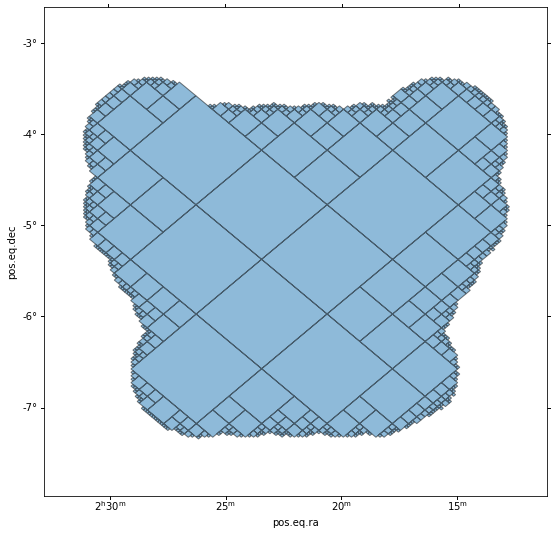

In [21]:
dmoc = MOC.from_skycoords(xmm_coord[mightee_snr > 0.], max_norder=11)
area = (dmoc.sky_fraction*4*np.pi*u.steradian).to(u.deg**2)

dmoc.write('../TargetCatalogues/ORCHIDSSwide-ddf_WD02_MOC.fits', overwrite=True)

fig = plt.figure(figsize=(9,9))

wcs = dmoc.wcs(fig)  # automatically creates a wcs for the MOC
ax1 = fig.add_subplot(111, projection=wcs)  # The first of a 2*2 grig of subplots

dmoc.fill(
    ax1,
    wcs,
    alpha=0.5,
)  # Where the MOC is added to the plot

#ax1.plot(scoord.ra.value, scoord.dec.value, 'o', ms=2, zorder=100, transform=ax1.get_transform(wcs))

print(f"Source density: {len(orchidsswide_xmm) / area:.1f}")
print(f"Total sample: {len(orchidsswide_xmm)}")